**SUMBER DATA:**

https://drive.google.com/file/d/1Sw-yO1lAqGTK_CBYXTbBP7HzuLHSdz4R/view?usp=sharing


Melakukan Import Path Python

In [ ]:
print(sys.path)

In [ ]:
sys.path.append("/anaconda3/envs/pbd/lib/python3.7/site-packages")

# Import Findspark

In [ ]:
import findspark
findspark.init()

# Inisiasi SparkSession

In [ ]:
import pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("bda").getOrCreate()

23/11/27 15:57:51 WARN Utils: Your hostname, rheza-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
23/11/27 15:57:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/11/27 15:57:52 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Import Library untuk Visualisasi

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Mengambil Data dari HDFS

In [ ]:
file_path = "hdfs://127.0.1.1:9000/matkul/bda/Mall_Customers2.csv"

# Membaca Data dan Menampilkan Data

In [ ]:
data = spark.read.csv(file_path, header=True, inferSchema=True)

In [ ]:
data.show(10, truncate=False)

+----------+------+---+------------------+----------------------+
|CustomerID|Gender|Age|Annual Income (k$)|Spending Score (1-100)|
+----------+------+---+------------------+----------------------+
|1         |Male  |19 |15                |39                    |
|2         |Male  |21 |15                |81                    |
|3         |Female|20 |16                |6                     |
|4         |Female|23 |16                |77                    |
|5         |Female|31 |17                |40                    |
|6         |Female|22 |17                |76                    |
|7         |Female|35 |18                |6                     |
|8         |Female|23 |18                |94                    |
|9         |Male  |64 |19                |3                     |
|10        |Female|30 |19                |72                    |
+----------+------+---+------------------+----------------------+
only showing top 10 rows



# Memproses Data Menggunakan Vector Assembler dan StandarScaler

In [ ]:
selected_features = data.select("Age", "Annual Income (k$)", "Spending Score (1-100)")

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

In [ ]:
assembler = VectorAssembler(inputCols=["Annual Income (k$)", "Spending Score (1-100)"], outputCol="features")
selected_features = assembler.transform(selected_features)



In [ ]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(selected_features)
selected_features = scaler_model.transform(selected_features)

# Menggunakan KMeans untuk Pengelompokan Data

In [ ]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(selected_features)

# Melakukan Prediksi dan Disimpan dalam Data Frame

In [ ]:
predictions = model.transform(selected_features)

In [ ]:
predictions.select("Annual Income (k$)", "Spending Score (1-100)", "prediction").show(19)

+------------------+----------------------+----------+
|Annual Income (k$)|Spending Score (1-100)|prediction|
+------------------+----------------------+----------+
|                15|                    39|         4|
|                15|                    81|         2|
|                16|                     6|         4|
|                16|                    77|         2|
|                17|                    40|         4|
|                17|                    76|         2|
|                18|                     6|         4|
|                18|                    94|         2|
|                19|                     3|         4|
|                19|                    72|         2|
|                19|                    14|         4|
|                19|                    99|         2|
|                20|                    15|         4|
|                20|                    77|         2|
|                20|                    13|         4|
|         

# Melakukan Visualisasi hasil KMeans

+-----------+----------+
|   features|prediction|
+-----------+----------+
|[15.0,39.0]|         4|
|[15.0,81.0]|         2|
| [16.0,6.0]|         4|
|[16.0,77.0]|         2|
|[17.0,40.0]|         4|
|[17.0,76.0]|         2|
| [18.0,6.0]|         4|
|[18.0,94.0]|         2|
| [19.0,3.0]|         4|
|[19.0,72.0]|         2|
|[19.0,14.0]|         4|
|[19.0,99.0]|         2|
|[20.0,15.0]|         4|
|[20.0,77.0]|         2|
|[20.0,13.0]|         4|
|[20.0,79.0]|         2|
|[21.0,35.0]|         4|
|[21.0,66.0]|         2|
|[23.0,29.0]|         4|
|[23.0,98.0]|         2|
+-----------+----------+
only showing top 20 rows



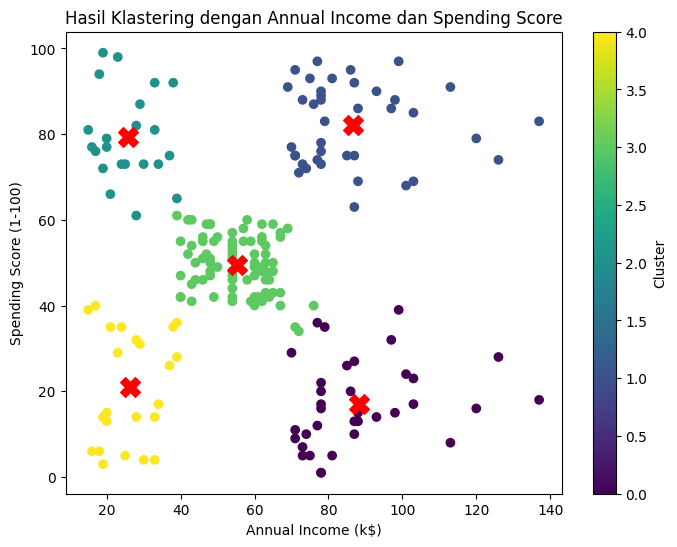

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans

# Mengambil kolom features dan prediction untuk visualisasi
features_and_predictions = predictions.select("features", "prediction")

# Mendefinisikan jumlah klaster (sesuaikan dengan kebutuhan Anda)
num_clusters = 5

# Menampilkan hasil klastering
features_and_predictions.show()

# Konversi ke Pandas DataFrame untuk memvisualisasikan dengan matplotlib
pandas_df = features_and_predictions.toPandas()

# Visualisasi scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pandas_df["features"].apply(lambda x: x[0]), pandas_df["features"].apply(lambda x: x[1]), c=pandas_df["prediction"], cmap="viridis")
plt.title("Hasil Klastering dengan Annual Income dan Spending Score")
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")

# Menambahkan legenda
legend = plt.colorbar(scatter)
legend.set_label('Cluster')

# Menambahkan centroid untuk setiap klaster
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_model.fit(pandas_df["features"].to_list())
centroids = kmeans_model.cluster_centers_

plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=200, c='red', label='Centroid')

plt.show()


# Evaluasi Hasil

In [ ]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print(f"Silhouette Score: {silhouette}")

Silhouette Score: 0.7397829244623759
